# FullClass-TrainCNN_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


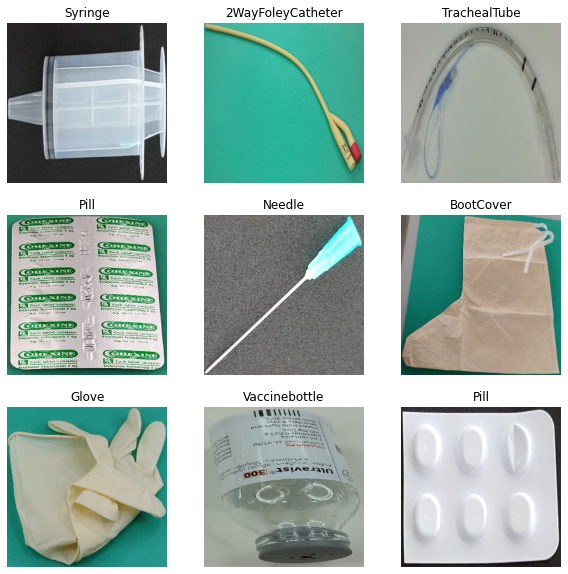

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception,preprocess_input

#                                                                                                                               VVVVVV  another model don't forgot to put softmax
transfered_model = keras.applications.Xception(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax") #

model_nooutput = transfered_model.layers[-2].output
custom_model = Model(inputs = transfered_model.input, outputs = model_nooutput)


## Freez Extractor+

In [18]:
custom_model.trainable = False
for layer in custom_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [19]:
#tf.keras.utils.plot_model(ResNet152_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                42025     
Total params: 23,001,681
Trainable params: 2,140,201
Non-trainable params: 20,861,480
_________________________________________________________________


In [22]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
#print(len(model.layers))
#tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [2]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Xception_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/'

In [25]:
EPOCHS = 2000
save_model_interval = 200
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 48s 431ms/step - loss: 1.1833 - accuracy: 0.6943 - val_loss: 0.4159 - val_accuracy: 0.8771
Epoch 2/2000
49/49 [==============================] - 16s 322ms/step - loss: 0.2715 - accuracy: 0.9228 - val_loss: 0.2361 - val_accuracy: 0.9237
Epoch 3/2000
49/49 [==============================] - 16s 323ms/step - loss: 0.1375 - accuracy: 0.9638 - val_loss: 0.2143 - val_accuracy: 0.9301
Epoch 4/2000
49/49 [==============================] - 16s 324ms/step - loss: 0.0909 - accuracy: 0.9796 - val_loss: 0.2106 - val_accuracy: 0.9224
Epoch 5/2000
49/49 [==============================] - 16s 324ms/step - loss: 0.0728 - accuracy: 0.9790 - val_loss: 0.1433 - val_accuracy: 0.9495
Epoch 6/2000
49/49 [==============================] - 16s 324ms/step - loss: 0.0505 - accuracy: 0.9871 - val_loss: 0.1781 - val_accuracy: 0.9379
Epoch 7/2000
49/49 [==============================] - 16s 324ms/step - loss: 0.0249 - accuracy: 0.9981 - val_loss: 0.1362 - val_ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 201/2000
49/49 [==============================] - 16s 323ms/step - loss: 4.5739e-04 - accuracy: 1.0000 - val_loss: 0.1073 - val_accuracy: 0.9625
Epoch 202/2000
49/49 [==============================] - 16s 324ms/step - loss: 4.3266e-04 - accuracy: 1.0000 - val_loss: 0.1077 - val_accuracy: 0.9625
Epoch 203/2000
49/49 [==============================] - 16s 325ms/step - loss: 4.4609e-04 - accuracy: 1.0000 - val_loss: 0.1080 - val_accuracy: 0.9625
Epoch 204/2000
49/49 [==============================] - 16s 325ms/step - loss: 4.5775e-04 - accuracy: 1.0000 - val_loss: 0.1076 - val_accuracy: 0.9625
Epoch 205/2000
49/49 [==============================] - 16s 325ms/step - loss: 4.8119e-04 - accuracy: 1.0000 - val_loss: 0.1074 - val_accuracy: 0.9625
Epoch 206/2000
49/49 [==============================] - 16s 325ms/step - loss: 4.4270e-04 - accuracy: 1.0000 - val_loss: 0.1066 - val_accuracy: 0.9651
Epoch 207/2000
49/49 [==============================] - 16s 326ms/step - loss: 4.2943e-04 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 401/2000
49/49 [==============================] - 16s 323ms/step - loss: 5.5206e-05 - accuracy: 1.0000 - val_loss: 0.1170 - val_accuracy: 0.9651
Epoch 402/2000
49/49 [==============================] - 16s 323ms/step - loss: 5.7028e-05 - accuracy: 1.0000 - val_loss: 0.1179 - val_accuracy: 0.9664
Epoch 403/2000
49/49 [==============================] - 16s 324ms/step - loss: 6.0721e-05 - accuracy: 1.0000 - val_loss: 0.1163 - val_accuracy: 0.9677
Epoch 404/2000
49/49 [==============================] - 16s 324ms/step - loss: 6.1553e-05 - accuracy: 1.0000 - val_loss: 0.1170 - val_accuracy: 0.9638
Epoch 405/2000
49/49 [==============================] - 16s 325ms/step - loss: 5.7137e-05 - accuracy: 1.0000 - val_loss: 0.1174 - val_accuracy: 0.9651
Epoch 406/2000
49/49 [==============================] - 16s 325ms/step - loss: 5.9138e-05 - accuracy: 1.0000 - val_loss: 0.1169 - val_accuracy: 0.9664
Epoch 407/2000
49/49 [==============================] - 16s 324ms/step - loss: 5.1650e-05 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 601/2000
49/49 [==============================] - 16s 322ms/step - loss: 1.0947e-05 - accuracy: 1.0000 - val_loss: 0.1302 - val_accuracy: 0.9651
Epoch 602/2000
49/49 [==============================] - 16s 324ms/step - loss: 1.1784e-05 - accuracy: 1.0000 - val_loss: 0.1289 - val_accuracy: 0.9651
Epoch 603/2000
49/49 [==============================] - 16s 324ms/step - loss: 1.0362e-05 - accuracy: 1.0000 - val_loss: 0.1290 - val_accuracy: 0.9638
Epoch 604/2000
49/49 [==============================] - 16s 324ms/step - loss: 1.0872e-05 - accuracy: 1.0000 - val_loss: 0.1289 - val_accuracy: 0.9638
Epoch 605/2000
49/49 [==============================] - 16s 324ms/step - loss: 1.0619e-05 - accuracy: 1.0000 - val_loss: 0.1291 - val_accuracy: 0.9651
Epoch 606/2000
49/49 [==============================] - 16s 324ms/step - loss: 1.0520e-05 - accuracy: 1.0000 - val_loss: 0.1292 - val_accuracy: 0.9651
Epoch 607/2000
49/49 [==============================] - 16s 325ms/step - loss: 9.9167e-06 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 801/2000
49/49 [==============================] - 16s 323ms/step - loss: 3.5521e-06 - accuracy: 1.0000 - val_loss: 0.1391 - val_accuracy: 0.9651
Epoch 802/2000
49/49 [==============================] - 16s 324ms/step - loss: 3.7245e-06 - accuracy: 1.0000 - val_loss: 0.1403 - val_accuracy: 0.9664
Epoch 803/2000
49/49 [==============================] - 16s 325ms/step - loss: 3.1443e-06 - accuracy: 1.0000 - val_loss: 0.1398 - val_accuracy: 0.9664
Epoch 804/2000
49/49 [==============================] - 16s 325ms/step - loss: 3.0148e-06 - accuracy: 1.0000 - val_loss: 0.1392 - val_accuracy: 0.9651
Epoch 805/2000
49/49 [==============================] - 16s 325ms/step - loss: 3.6249e-06 - accuracy: 1.0000 - val_loss: 0.1389 - val_accuracy: 0.9651
Epoch 806/2000
49/49 [==============================] - 16s 325ms/step - loss: 3.3732e-06 - accuracy: 1.0000 - val_loss: 0.1379 - val_accuracy: 0.9651
Epoch 807/2000
49/49 [==============================] - 16s 325ms/step - loss: 3.4169e-06 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1001/2000
49/49 [==============================] - 16s 323ms/step - loss: 1.4551e-06 - accuracy: 1.0000 - val_loss: 0.1473 - val_accuracy: 0.9638
Epoch 1002/2000
49/49 [==============================] - 16s 324ms/step - loss: 1.5041e-06 - accuracy: 1.0000 - val_loss: 0.1471 - val_accuracy: 0.9638
Epoch 1003/2000
49/49 [==============================] - 16s 324ms/step - loss: 1.5072e-06 - accuracy: 1.0000 - val_loss: 0.1474 - val_accuracy: 0.9651
Epoch 1004/2000
49/49 [==============================] - 16s 325ms/step - loss: 1.4927e-06 - accuracy: 1.0000 - val_loss: 0.1471 - val_accuracy: 0.9638
Epoch 1005/2000
49/49 [==============================] - 16s 325ms/step - loss: 1.4485e-06 - accuracy: 1.0000 - val_loss: 0.1467 - val_accuracy: 0.9638
Epoch 1006/2000
49/49 [==============================] - 16s 325ms/step - loss: 1.4132e-06 - accuracy: 1.0000 - val_loss: 0.1463 - val_accuracy: 0.9638
Epoch 1007/2000
49/49 [==============================] - 16s 325ms/step - loss: 1.8084e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1201/2000
49/49 [==============================] - 16s 323ms/step - loss: 8.8437e-07 - accuracy: 1.0000 - val_loss: 0.1531 - val_accuracy: 0.9651
Epoch 1202/2000
49/49 [==============================] - 16s 324ms/step - loss: 8.5260e-07 - accuracy: 1.0000 - val_loss: 0.1533 - val_accuracy: 0.9651
Epoch 1203/2000
49/49 [==============================] - 16s 325ms/step - loss: 8.0234e-07 - accuracy: 1.0000 - val_loss: 0.1531 - val_accuracy: 0.9651
Epoch 1204/2000
49/49 [==============================] - 16s 325ms/step - loss: 7.9244e-07 - accuracy: 1.0000 - val_loss: 0.1532 - val_accuracy: 0.9638
Epoch 1205/2000
49/49 [==============================] - 16s 326ms/step - loss: 7.9544e-07 - accuracy: 1.0000 - val_loss: 0.1534 - val_accuracy: 0.9638
Epoch 1206/2000
49/49 [==============================] - 16s 325ms/step - loss: 8.6970e-07 - accuracy: 1.0000 - val_loss: 0.1530 - val_accuracy: 0.9651
Epoch 1207/2000
49/49 [==============================] - 16s 325ms/step - loss: 8.9119e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1401/2000
49/49 [==============================] - 16s 322ms/step - loss: 5.3561e-07 - accuracy: 1.0000 - val_loss: 0.1579 - val_accuracy: 0.9638
Epoch 1402/2000
49/49 [==============================] - 16s 324ms/step - loss: 8.5878e-07 - accuracy: 1.0000 - val_loss: 0.1592 - val_accuracy: 0.9638
Epoch 1403/2000
49/49 [==============================] - 16s 324ms/step - loss: 6.8732e-07 - accuracy: 1.0000 - val_loss: 0.1592 - val_accuracy: 0.9664
Epoch 1404/2000
49/49 [==============================] - 16s 324ms/step - loss: 7.0485e-07 - accuracy: 1.0000 - val_loss: 0.1591 - val_accuracy: 0.9651
Epoch 1405/2000
49/49 [==============================] - 16s 325ms/step - loss: 5.1920e-07 - accuracy: 1.0000 - val_loss: 0.1591 - val_accuracy: 0.9651
Epoch 1406/2000
49/49 [==============================] - 16s 325ms/step - loss: 6.2724e-07 - accuracy: 1.0000 - val_loss: 0.1590 - val_accuracy: 0.9625
Epoch 1407/2000
49/49 [==============================] - 16s 325ms/step - loss: 7.3143e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1601/2000
49/49 [==============================] - 16s 323ms/step - loss: 4.0023e-07 - accuracy: 1.0000 - val_loss: 0.1606 - val_accuracy: 0.9664
Epoch 1602/2000
49/49 [==============================] - 16s 324ms/step - loss: 3.9876e-07 - accuracy: 1.0000 - val_loss: 0.1607 - val_accuracy: 0.9664
Epoch 1603/2000
49/49 [==============================] - 16s 325ms/step - loss: 4.0300e-07 - accuracy: 1.0000 - val_loss: 0.1606 - val_accuracy: 0.9664
Epoch 1604/2000
49/49 [==============================] - 16s 325ms/step - loss: 4.3088e-07 - accuracy: 1.0000 - val_loss: 0.1604 - val_accuracy: 0.9664
Epoch 1605/2000
49/49 [==============================] - 16s 325ms/step - loss: 4.0427e-07 - accuracy: 1.0000 - val_loss: 0.1603 - val_accuracy: 0.9651
Epoch 1606/2000
49/49 [==============================] - 16s 325ms/step - loss: 4.0608e-07 - accuracy: 1.0000 - val_loss: 0.1601 - val_accuracy: 0.9651
Epoch 1607/2000
49/49 [==============================] - 16s 325ms/step - loss: 3.7030e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1801/2000
49/49 [==============================] - 16s 323ms/step - loss: 2.9627e-07 - accuracy: 1.0000 - val_loss: 0.1637 - val_accuracy: 0.9638
Epoch 1802/2000
49/49 [==============================] - 16s 324ms/step - loss: 3.3394e-07 - accuracy: 1.0000 - val_loss: 0.1639 - val_accuracy: 0.9638
Epoch 1803/2000
49/49 [==============================] - 16s 324ms/step - loss: 3.1325e-07 - accuracy: 1.0000 - val_loss: 0.1639 - val_accuracy: 0.9651
Epoch 1804/2000
49/49 [==============================] - 16s 324ms/step - loss: 3.0605e-07 - accuracy: 1.0000 - val_loss: 0.1650 - val_accuracy: 0.9651
Epoch 1805/2000
49/49 [==============================] - 16s 325ms/step - loss: 3.4468e-07 - accuracy: 1.0000 - val_loss: 0.1644 - val_accuracy: 0.9651
Epoch 1806/2000
49/49 [==============================] - 16s 325ms/step - loss: 3.0848e-07 - accuracy: 1.0000 - val_loss: 0.1642 - val_accuracy: 0.9651
Epoch 1807/2000
49/49 [==============================] - 16s 325ms/step - loss: 2.8202e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Training and Validation Accuracy')

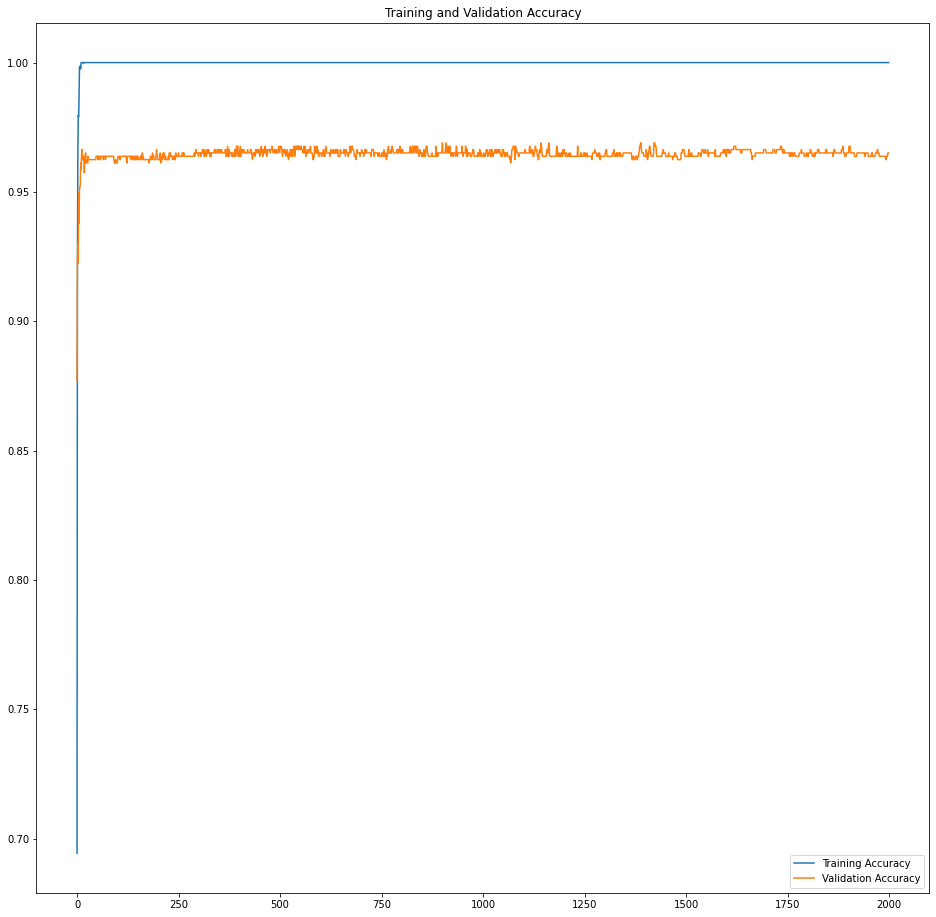

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


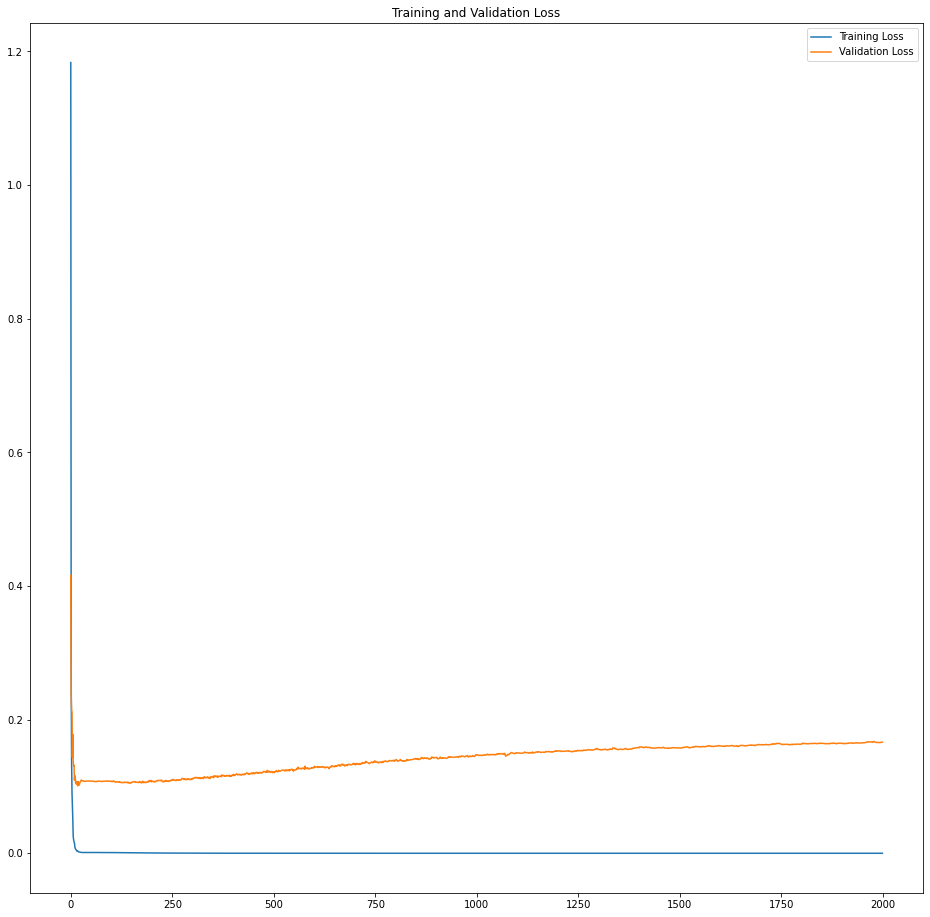

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 359ms/step - loss: 0.9057 - accuracy: 0.8489
test_indoor_ds_results:test loss, test acc: [0.9057430028915405, 0.848940908908844]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 26s 438ms/step - loss: 2.0328 - accuracy: 0.7545
test_outdoor_ds_results:test loss, test acc: [2.0328004360198975, 0.7544586062431335]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 11s 281ms/step - loss: 2.3902 - accuracy: 0.7167
test_belt_ds_results:test loss, test acc: [2.390249729156494, 0.7166817784309387]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Xception_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200.pb',
 'D:/ModelMedicalWasteCheckpoint/Xception_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0400.pb',
 'D:/ModelMedicalWasteCheckpoint/Xception_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0600.pb',
 'D:/ModelMedicalWasteCheckpoint/Xception_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0800.pb',
 'D:/ModelMedicalWasteCheckpoint/Xception_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1000.

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 9s 258ms/step - loss: 1.5081 - accuracy: 0.7162
Epoch200 
 test_indoor_acc=0.843366801738739 
 test_outdoor_acc=0.7560509443283081 
 test_belt_acc=0.7162284851074219
35/35 [==============================] - 9s 259ms/step - loss: 1.7335 - accuracy: 0.7162
Epoch400 
 test_indoor_acc=0.8461538553237915 
 test_outdoor_acc=0.7525477409362793 
 test_belt_acc=0.7162284851074219
35/35 [==============================] - 9s 258ms/step - loss: 1.9199 - accuracy: 0.7144
Epoch600 
 test_indoor_acc=0.8494983315467834 
 test_outdoor_acc=0.7550955414772034 
 test_belt_acc=0.7144152522087097
35/35 [==============================] - 9s 262ms/step - loss: 2.0711 - accuracy: 0.7144
Epoch800 
 test_indoor_acc=0.8478260636329651 
 test_outdoor_acc=0.7554140090942383 
 test_belt_acc=0.7144152522087097
35/35 [==============================] - 9s 258ms/step - loss: 2.1642 - accuracy: 0.7153
Epoch1000 
 test_indoor_acc=0.848940908908844 
 test_outdoor_acc=0.7550955414772

In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(200, 2200, 200)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

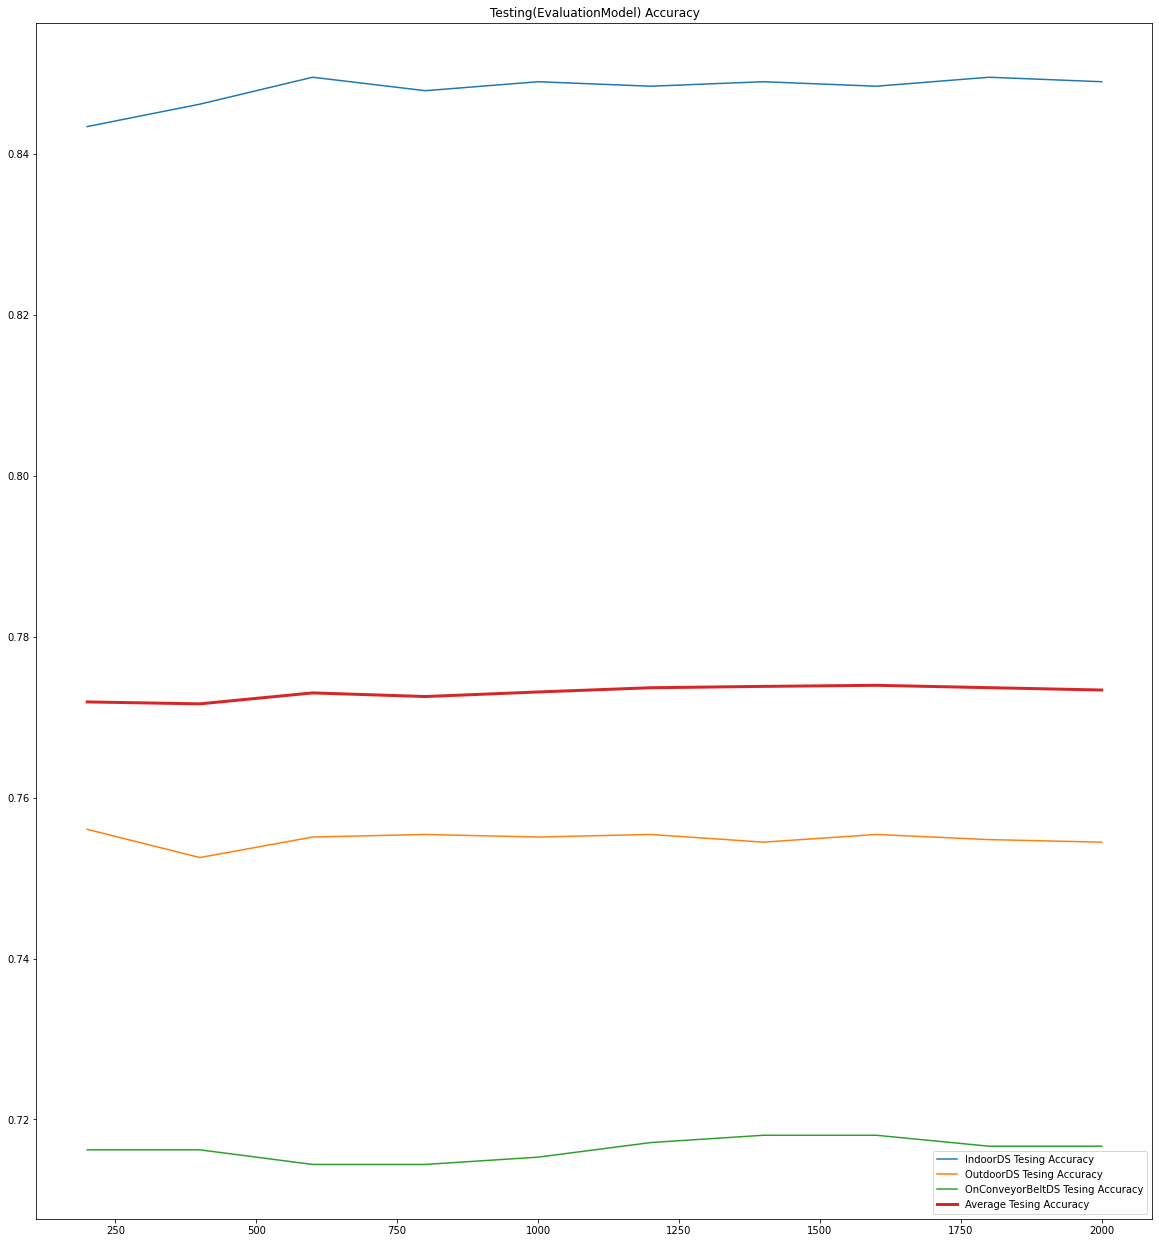

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7739464044570923
max index -> 7
The [Epoch] of max acc -> 1600


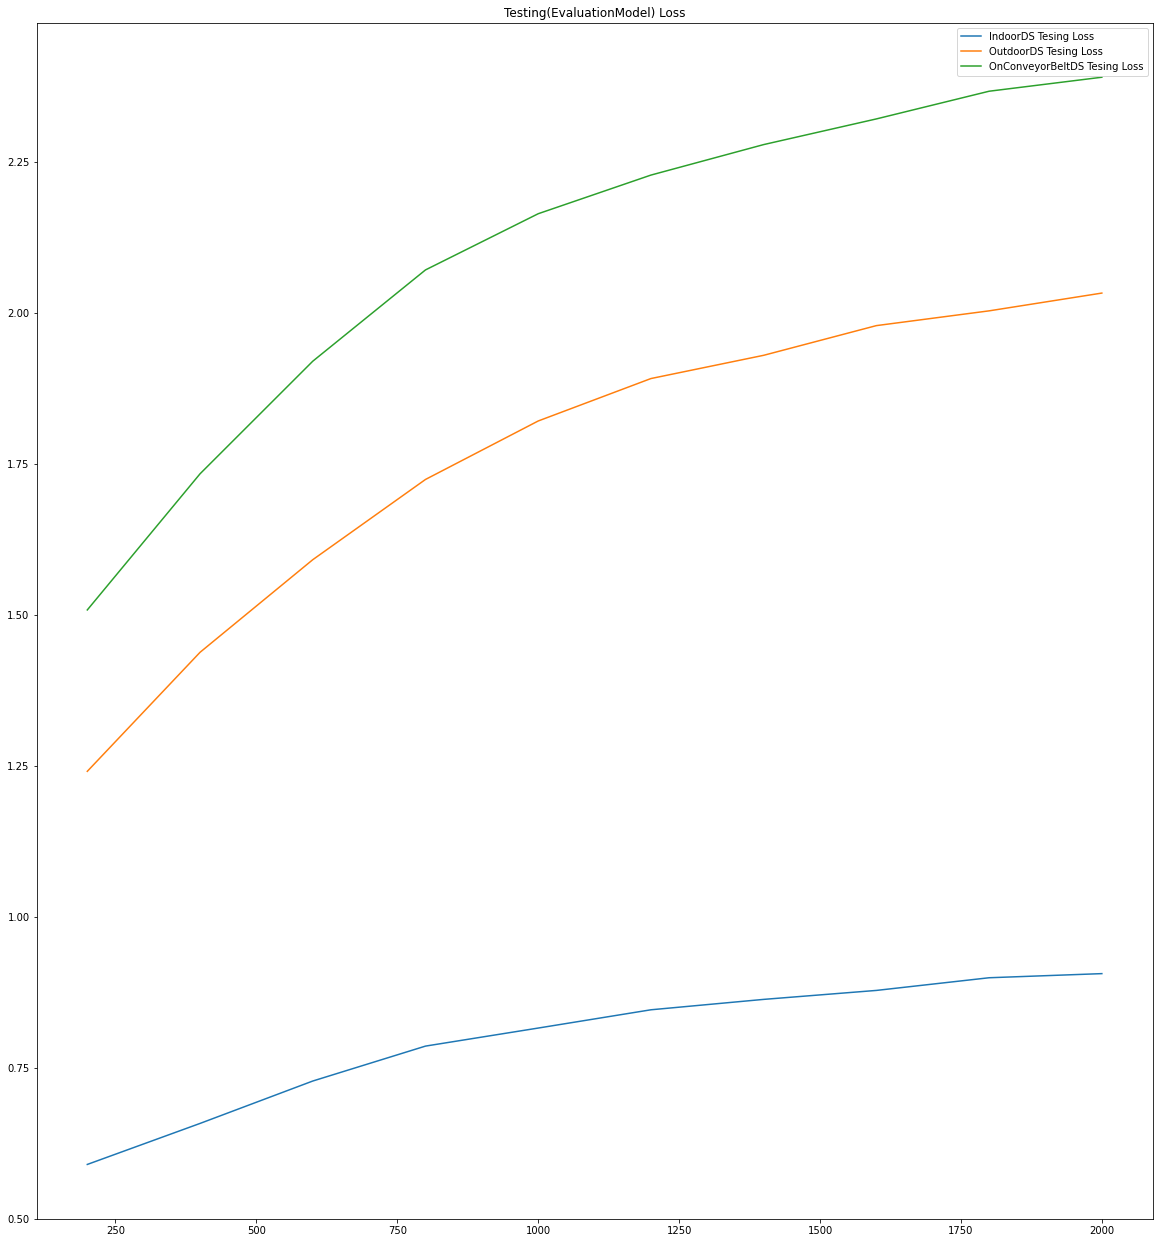

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.843366801738739,
 0.8461538553237915,
 0.8494983315467834,
 0.8478260636329651,
 0.848940908908844,
 0.8483834862709045,
 0.848940908908844,
 0.8483834862709045,
 0.8494983315467834,
 0.848940908908844]

In [38]:
test_outdoor_acc

[0.7560509443283081,
 0.7525477409362793,
 0.7550955414772034,
 0.7554140090942383,
 0.7550955414772034,
 0.7554140090942383,
 0.7544586062431335,
 0.7554140090942383,
 0.7547770738601685,
 0.7544586062431335]

In [39]:
test_belt_acc

[0.7162284851074219,
 0.7162284851074219,
 0.7144152522087097,
 0.7144152522087097,
 0.7153218388557434,
 0.7171350717544556,
 0.718041718006134,
 0.718041718006134,
 0.7166817784309387,
 0.7166817784309387]

In [40]:
test_indoor_loss

[0.5897314548492432,
 0.6576484441757202,
 0.7278684377670288,
 0.7857115268707275,
 0.8155947327613831,
 0.8458535671234131,
 0.86307692527771,
 0.8779272437095642,
 0.8989105224609375,
 0.9057430028915405]

In [41]:
test_outdoor_loss

[1.2407554388046265,
 1.437868595123291,
 1.5912325382232666,
 1.7241339683532715,
 1.8209840059280396,
 1.891256332397461,
 1.929736852645874,
 1.9789180755615234,
 2.0033650398254395,
 2.0328004360198975]

In [42]:
test_belt_loss

[1.5080516338348389,
 1.7334671020507812,
 1.9199451208114624,
 2.0711472034454346,
 2.164217710494995,
 2.228214740753174,
 2.278717517852783,
 2.3212337493896484,
 2.3670902252197266,
 2.390249729156494]

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.xception import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1600.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=32

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
### VRAM not enough -> we split into N set
del x_test_indoor,x_test_outdoor,x_test_belt
N = 200
x_all_sets = np.array_split(x_all, N)
del x_all
y_all_sets_predicted = []
for x in x_all_sets:
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=batch_size))
y_all_predicted = np.concatenate(y_all_sets_predicted)


Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [4]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5478
FP=1662
acc=0.7672268907563026
all check = 7140


### acc

In [5]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 80.17241379310344%
2WayConnectorforFoley acc = 93.87755102040816%
2WayFoleyCatheter acc = 73.88059701492537%
3WayConnectorforFoley acc = 96.58119658119658%
3Waystopcock acc = 99.09909909909909%
AlcoholBottle acc = 86.875%
AlcoholPad acc = 42.06349206349206%
BootCover acc = 64.45783132530121%
CottonBall acc = 94.61077844311377%
CottonSwap acc = 69.93006993006993%
Dilator acc = 76.92307692307693%
DisposableInfusionSet acc = 56.63716814159292%
ExtensionTube acc = 36.58536585365854%
FaceShield acc = 69.75308641975309%
FrontLoadSyringe acc = 52.21238938053098%
GauzePad acc = 53.97727272727273%
Glove acc = 78.57142857142857%
GuideWire acc = 44.642857142857146%
LiquidBottle acc = 64.12213740458014%
Mask acc = 97.40259740259741%
NGTube acc = 50.967741935483865%
NasalCannula acc = 31.858407079646017%
Needle acc = 91.42857142857143%
OxygenMask acc = 87.96992481203007%
PPESuit acc = 92.74193548387096%
PharmaceuticalProduct acc = 65.18691588785047%
Pill acc = 95.9383753

In [6]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 93,   0,   0, ...,   0,   0,   0],
       [  1, 138,   0, ...,   0,   0,   0],
       [  0,   0,  99, ...,   2,   0,  15],
       ...,
       [  0,   0,   0, ...,  78,   0,   0],
       [  0,   0,   0, ...,   0, 176,   0],
       [  0,   0,   0, ...,   0,   0,  91]], dtype=int64)

In [7]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[80.17241379,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68027211, 93.87755102,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 73.88059701, ...,  1.49253731,
         0.        , 11.19402985],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 65.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        82.62910798,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 79.8245614 ]])

<AxesSubplot:>

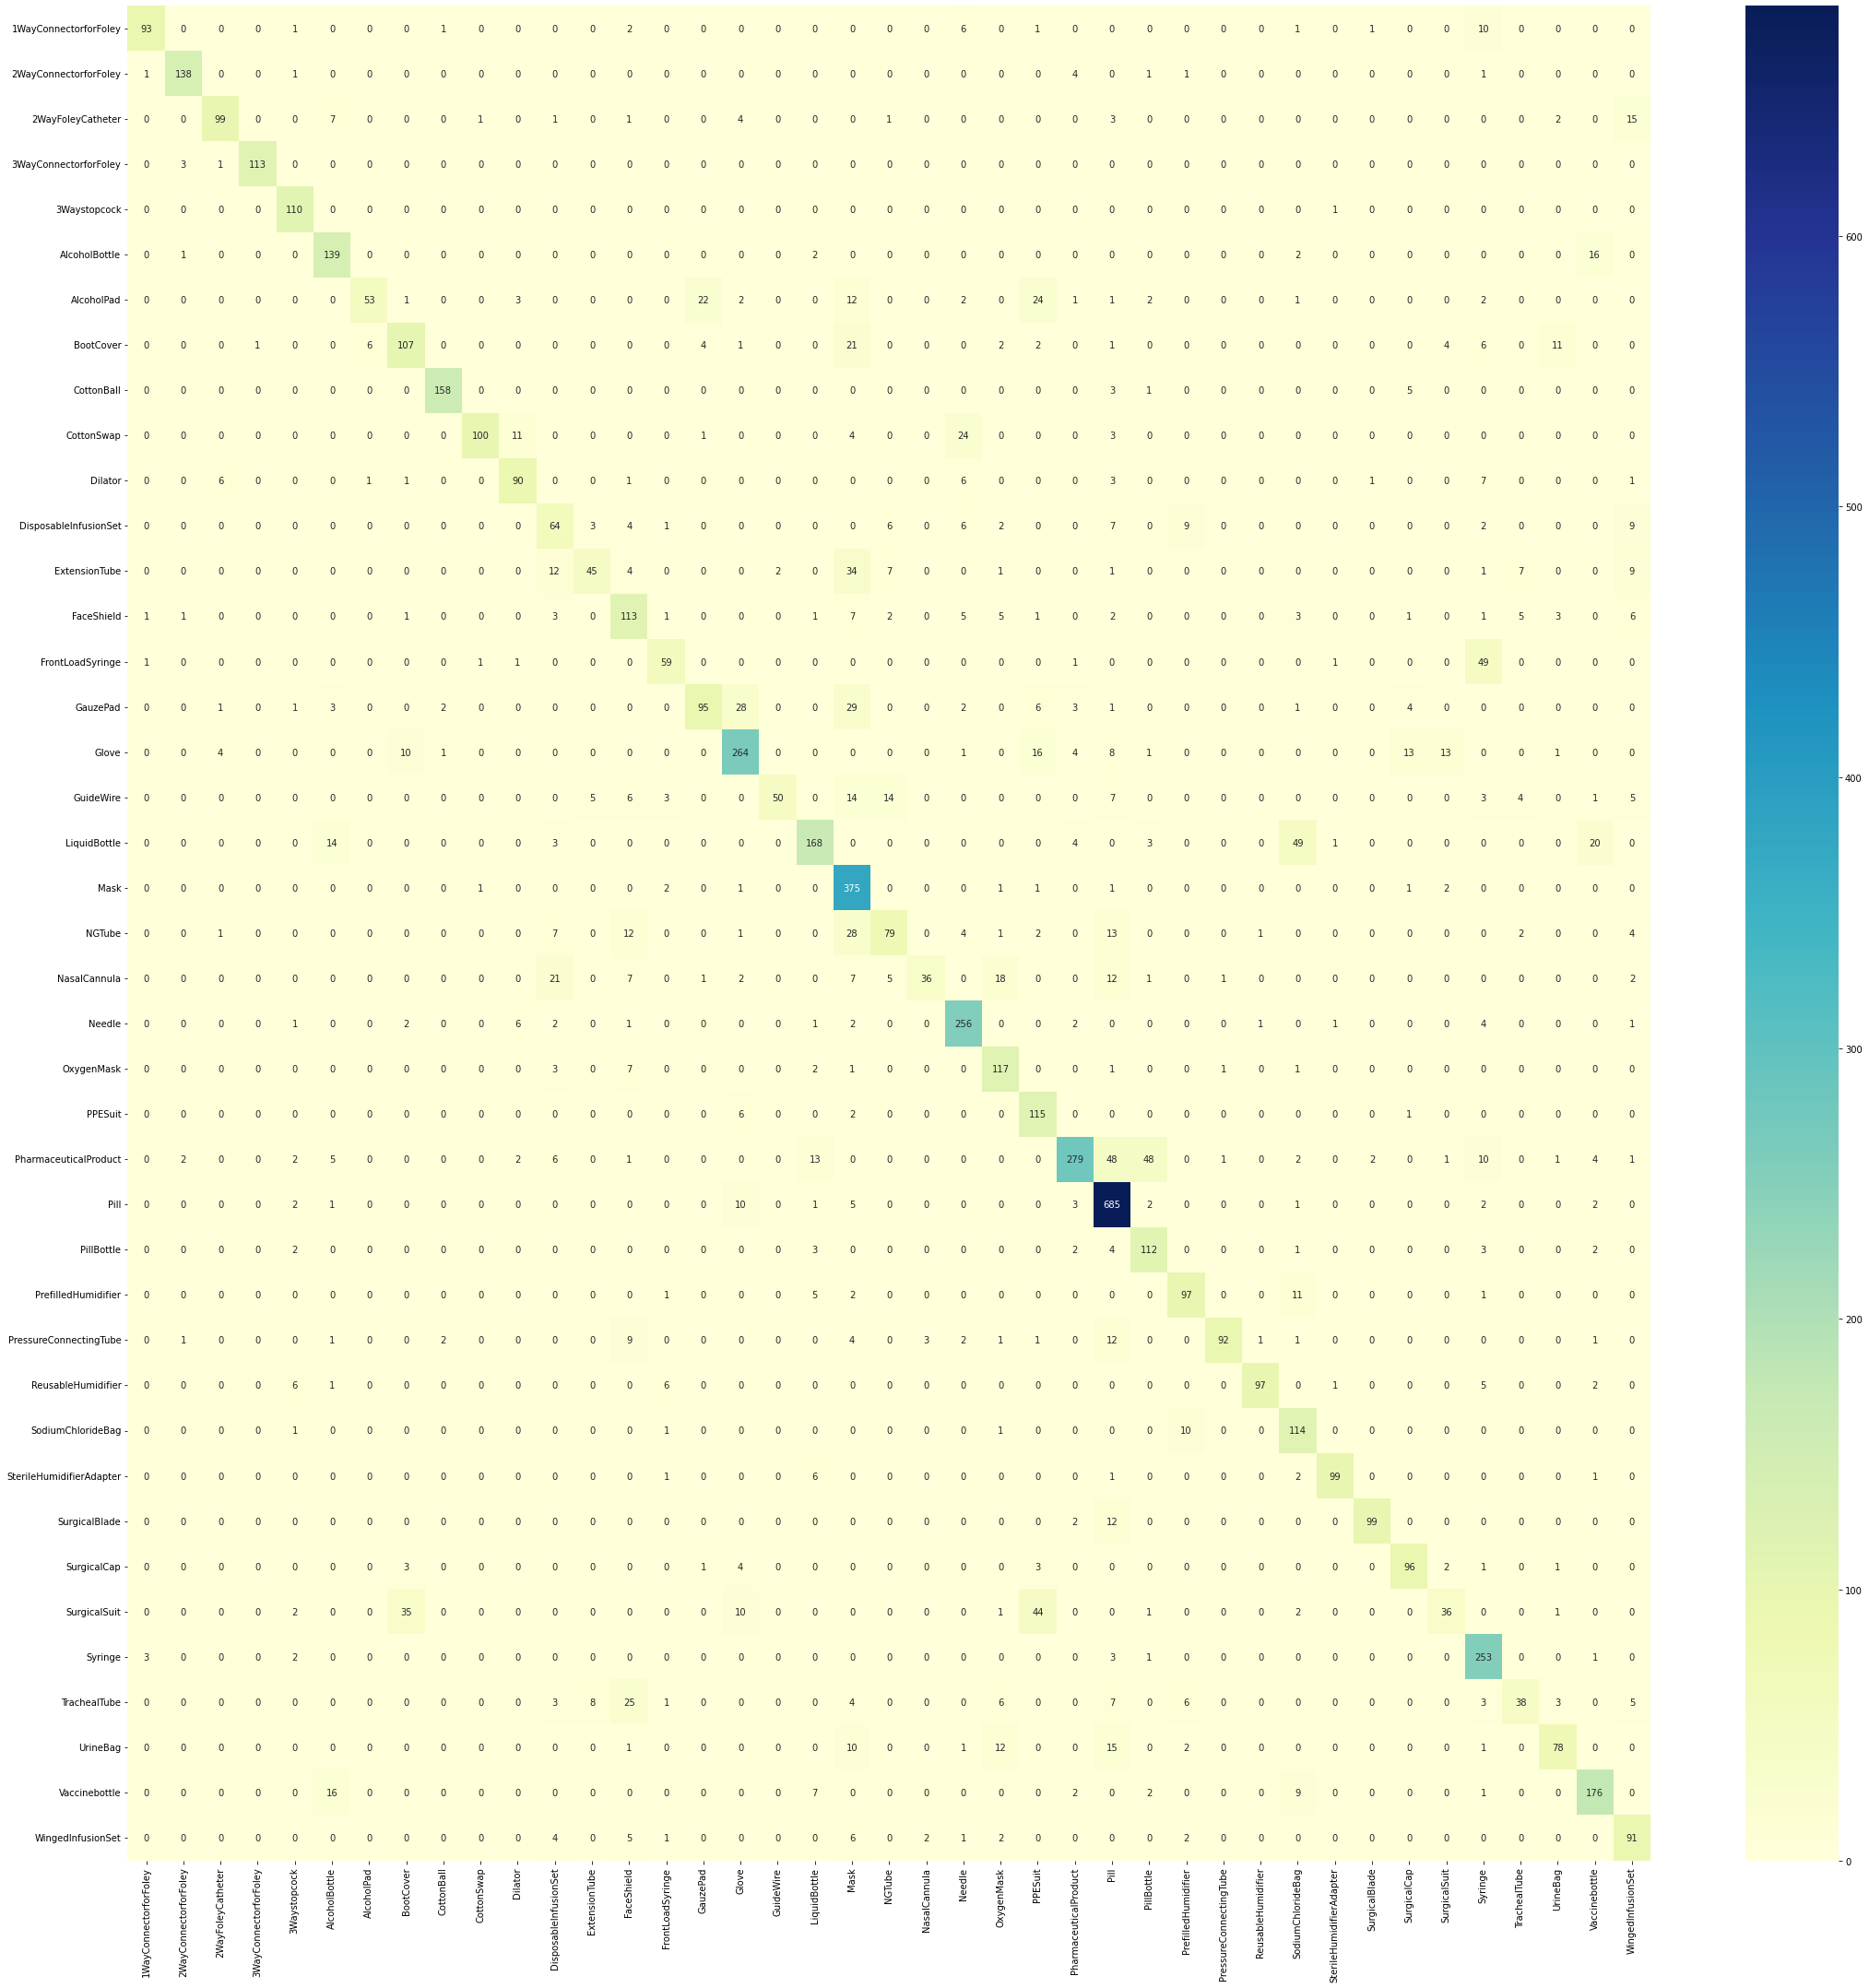

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

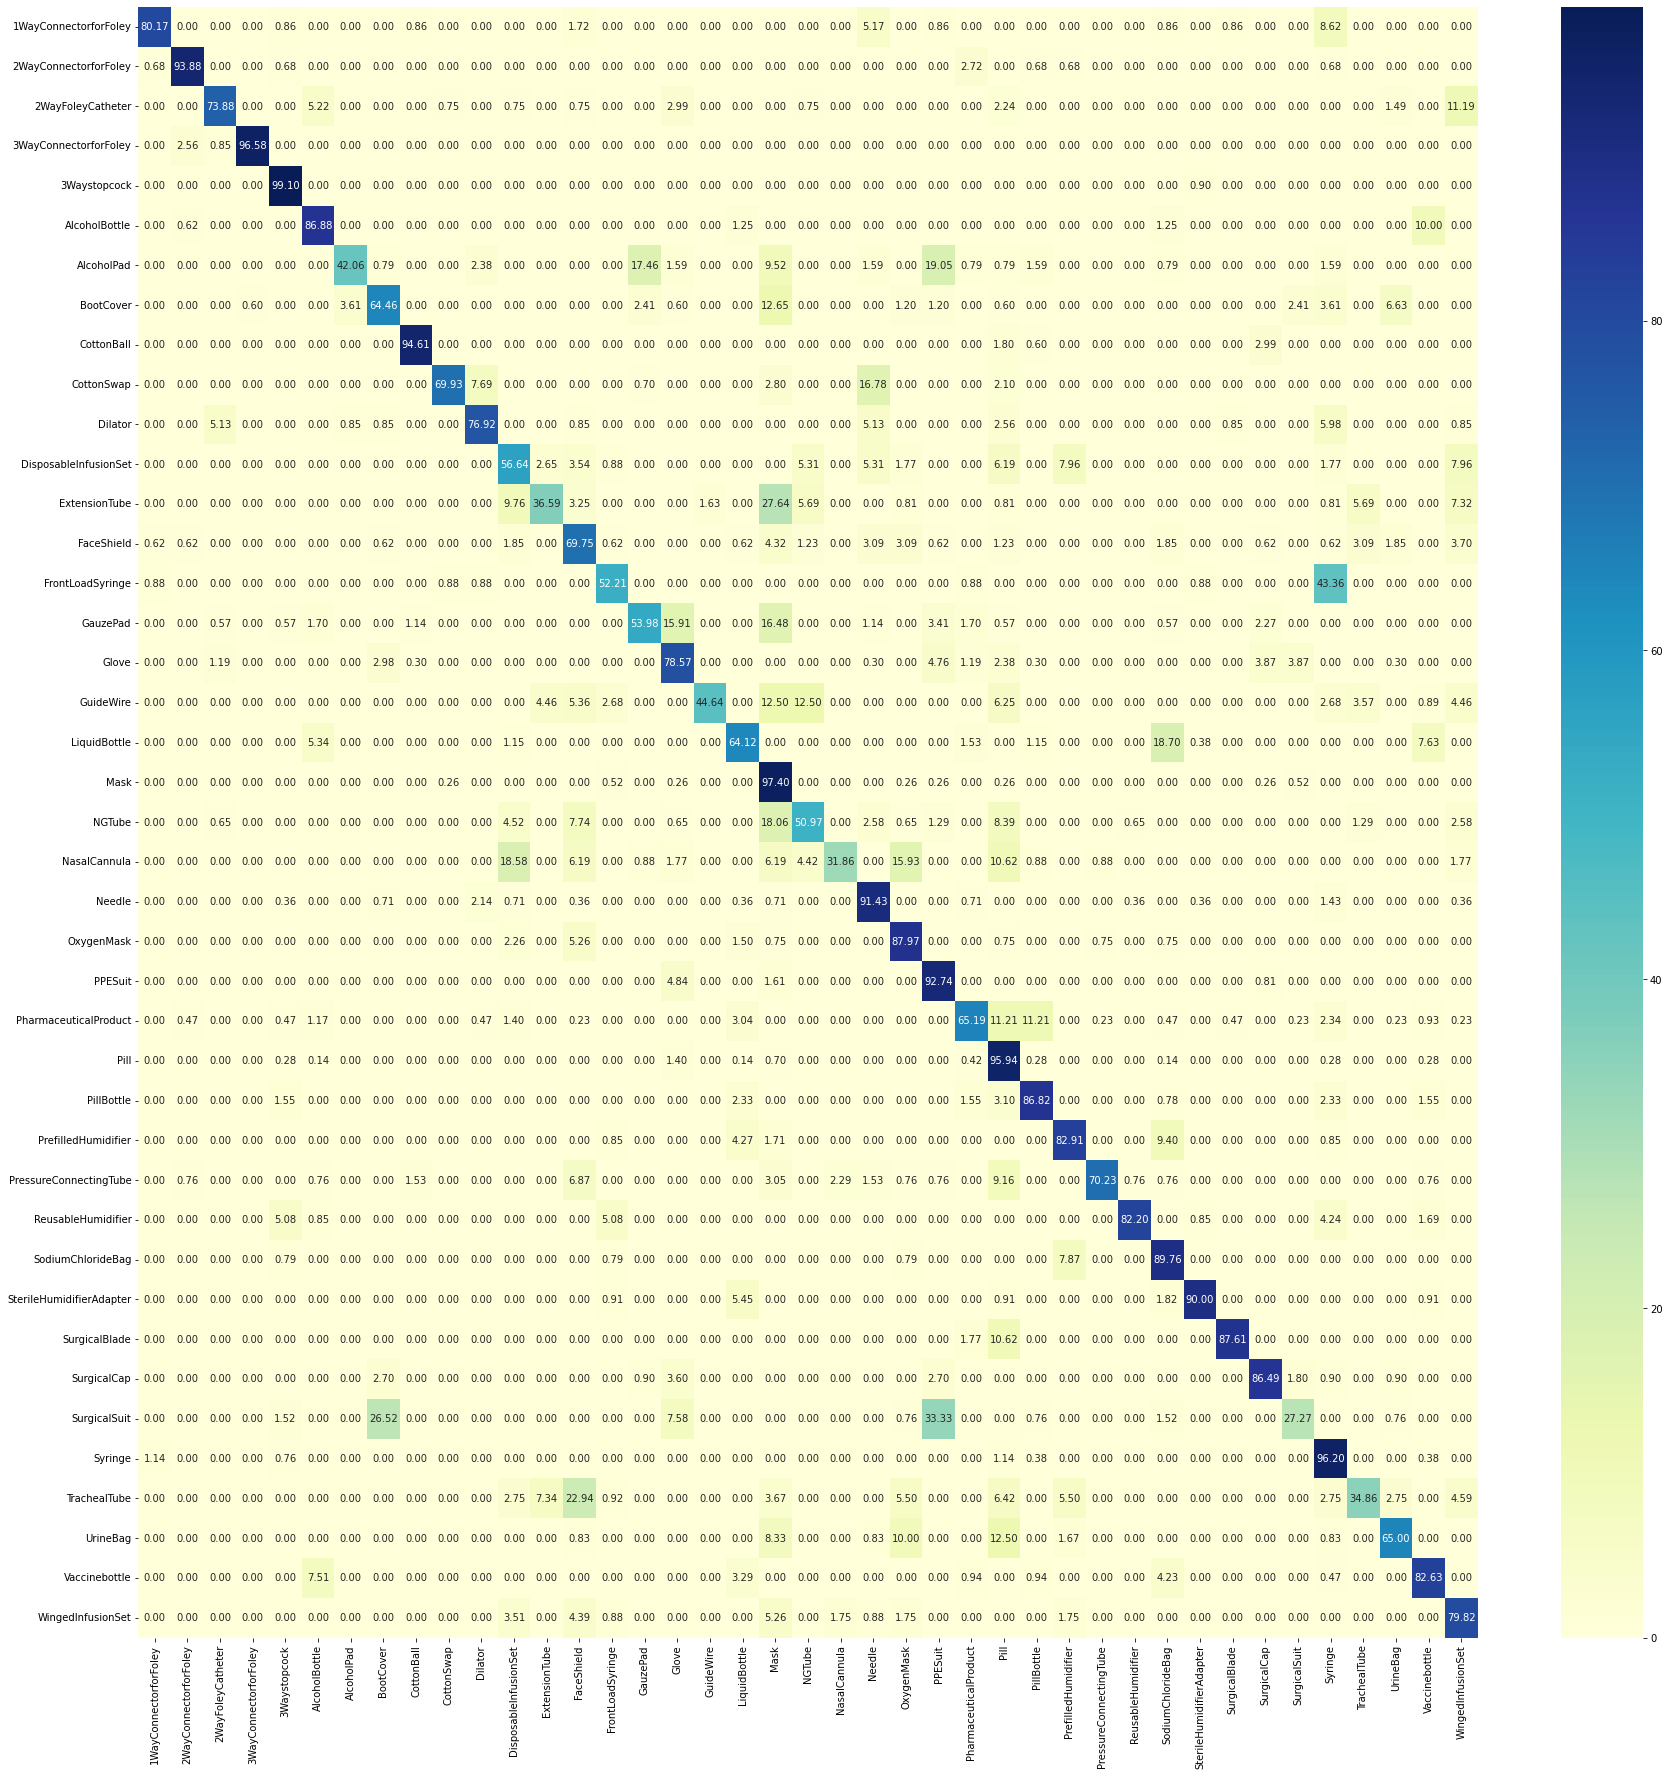

In [9]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")